In [30]:
 # need notebook backend for interaction
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

# file-handling stuff for user, options abound! I like Tables and Pandas DataFrames
import pandas as pd
from astropy.table import Table
from astropy import units as u
from specutils import Spectrum1D

# import kosmos... if we do it right this should be the only other thing to import someday!
import sys  
sys.path.append('/Users/james/Dropbox/research_projects/kosmos/')

import kosmos
kosmos.__version__

'0.02'

In [4]:
# let's reduce QY Aur (and GD 71) in Blue-Low and Red-Center modes

# BLUE LOW
# int_neon_gd71.0001.fits
# int_kry_gd71.0001.fits
# gd71.0001.fits
# qyaur.0001.fits

# RED CENTER
# int_neon_gd71.0004.fits
# gd71.0004.fits
# qyaur.0002.fits


In [150]:
biasfiles = pd.read_table('biaslist.txt', names=['impath'])['impath'].values
bias = kosmos.biascombine(biasfiles) 

flatfiles = ['truss_quartz_gd71.0001.fits']
flat, ilum = kosmos.flatcombine(flatfiles, bias=bias, 
                                trim=False, illumcor=True, 
                                responsecor=True, Waxis=0, Saxis=1)

Xfile = kosmos.obs_extinction('apoextinct.dat')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
 [astropy.io.fits.verify]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:316: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:316: RuntimeWarning: invalid value encountered in sqrt
  flu

<IPython.core.display.Javascript object>


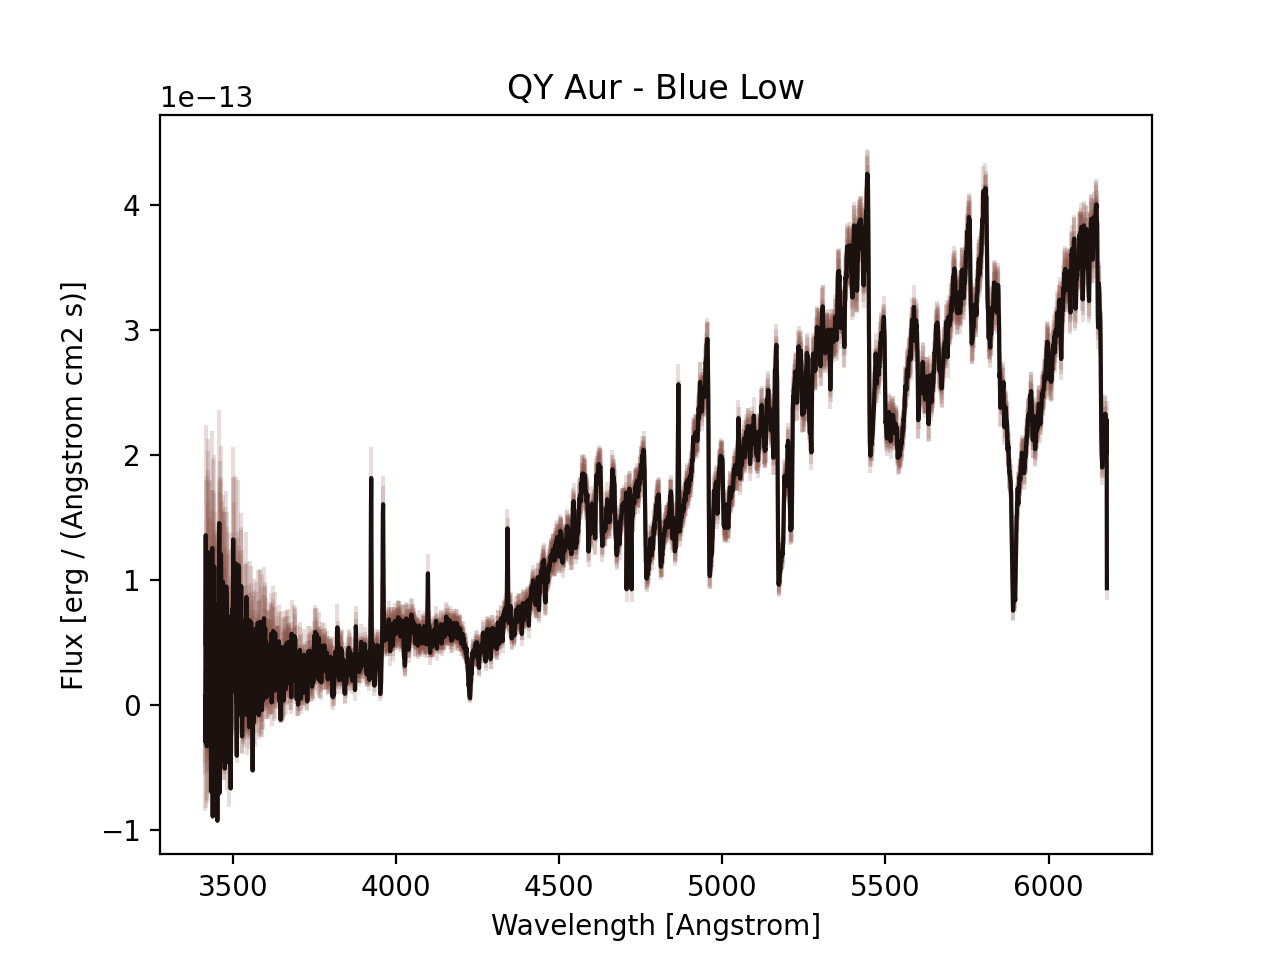

Text(0.5, 1.0, 'QY Aur - Blue Low')

In [153]:
# BLUE-LOW first
fcal = 'gd71.0001.fits'  # spectrum of standard star, GD71
calimg = kosmos.proc(fcal, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0)

sci = 'qyaur.0001.fits' # spectrum of M dwarf, QY Aur
sciimg = kosmos.proc(sci, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0)


cal_trace = kosmos.trace(calimg, display=False, nbins=15, Waxis=0, window=50)
sci_trace = kosmos.trace(sciimg, display=False, nbins=15, Waxis=0, window=50)

sci_ex, sci_sky = kosmos.BoxcarExtract(sciimg, sci_trace, display=False,
                                       apwidth=10, skysep=10, skywidth=10, Waxis=0)
cal_ex, cal_sky = kosmos.BoxcarExtract(calimg, cal_trace, display=False, 
                                       apwidth=10, skysep=10, skywidth=10, Waxis=0)

cal_spectrum = cal_ex - cal_sky
sci_spectrum = sci_ex - sci_sky

arcfile1 = 'int_neon_gd71.0001.fits'
arcfile2 = 'int_kry_gd71.0001.fits'

arcimg1 = kosmos.proc(arcfile1, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0) 
arcimg2 = kosmos.proc(arcfile2, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0) 

sciNe_ex, _ = kosmos.BoxcarExtract(arcimg1, sci_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)
sciKr_ex, _ = kosmos.BoxcarExtract(arcimg2, sci_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)
calNe_ex, _ = kosmos.BoxcarExtract(arcimg1, cal_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)
calKr_ex, _ = kosmos.BoxcarExtract(arcimg2, cal_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)

sciarc = sciNe_ex/100
sciarc = sciarc + sciKr_ex

calarc = calNe_ex/100
calarc = calarc + calKr_ex

# our blue template
df_spec1 = pd.read_csv('blue_low_Krypton_gp.spec')
df_spec2 = pd.read_csv('blue_low_Neon_gp.spec')

# make it w/ just Kr and Ne (internals), and scale Neon/100
blue_low = Spectrum1D(spectral_axis=df_spec1['wave'].values * u.angstrom,
                      flux=(df_spec1['flux'].values + 
                            (df_spec2['flux'].values/100)) * u.adu)

xbl,wbl = kosmos.identify_dtw(sciarc, blue_low, upsample=False, 
                            open_begin=True, open_end=True, step_pattern='asymmetric',
                            display=False, peak_spline=True, pthreshold=0.93)

sci_fit, _ = kosmos.fit_wavelength(sci_spectrum, xbl, wbl, mode='gp', display=False, 
                                        returnvar=True, GPRscale=101)

xbl,wbl = kosmos.identify_dtw(calarc, blue_low, upsample=False, 
                            open_begin=True, open_end=True, step_pattern='asymmetric',
                            display=False, peak_spline=True, pthreshold=0.93)

cal_fit, _ = kosmos.fit_wavelength(cal_spectrum, xbl, wbl, mode='gp', display=False, 
                                        returnvar=True, GPRscale=101)

ZD = sciimg.header['ZD'] / 180.0 * np.pi
sci_airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion
ZD = calimg.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)
cal_fitX = kosmos.airmass_cor(cal_fit, cal_airmass, Xfile)
sci_fitX = kosmos.airmass_cor(sci_fit, sci_airmass, Xfile)

standardstar = kosmos.onedstd('others/gd71.dat')
sensfunc = kosmos.standard_sensfunc(cal_fitX, standardstar, mode='poly', polydeg=9, display=False)

final_bluelow = kosmos.apply_sensfunc(sci_fitX, sensfunc)

plt.plot(final_bluelow.wavelength, final_bluelow.flux, c='k')
plt.errorbar(final_bluelow.wavelength.value, final_bluelow.flux.value, 
             yerr=final_bluelow.uncertainty.array, alpha=0.2, c='C5')

plt.xlabel('Wavelength ['+str(final_bluelow.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_bluelow.flux.unit)+']')
plt.title('QY Aur - Blue Low')


In [228]:
# RED CENTER
# fcal = 'gd71.0004.fits'  # spectrum of standard star, GD71... its off the slit, doh.
fcal = 'bd28_4211.0001.fits'  # spectrum of standard star BD+28
calimg = kosmos.proc(fcal, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0)

sci = 'qyaur.0002.fits' # spectrum of M dwarf, QY Aur
sciimg = kosmos.proc(sci, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0)

cal_trace = kosmos.trace(calimg, display=False, nbins=15, Waxis=0, window=50)
sci_trace = kosmos.trace(sciimg, display=False, nbins=15, Waxis=0, window=50)

sci_ex, sci_sky = kosmos.BoxcarExtract(sciimg, sci_trace, display=False,
                                       apwidth=10, skysep=10, skywidth=10, Waxis=0)
cal_ex, cal_sky = kosmos.BoxcarExtract(calimg, cal_trace, display=False, 
                                       apwidth=10, skysep=10, skywidth=10, Waxis=0)

cal_spectrum = cal_ex - cal_sky
sci_spectrum = sci_ex - sci_sky

arcfile1 = 'int_neon_qyaur.0002.fits'
arcfile2 = 'int_neon_bd28_4211.0001.fits'

arcimg1 = kosmos.proc(arcfile1, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0) 
arcimg2 = kosmos.proc(arcfile2, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0) 

sciNe_ex, _ = kosmos.BoxcarExtract(arcimg1, sci_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)
calNe_ex, _ = kosmos.BoxcarExtract(arcimg2, cal_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)
# sciKr_ex, _ = kosmos.BoxcarExtract(arcimg2, sci_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)
# calKr_ex, _ = kosmos.BoxcarExtract(arcimg2, cal_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)

sciarc = sciNe_ex/100
# sciarc = sciarc + sciKr_ex

calarc = calNe_ex/100
# calarc = calarc + calKr_ex

# our red template
df_spec1 = pd.read_csv('red_center_Neon_gp.spec')
# df_spec2 = pd.read_csv('blue_low_Neon_gp.spec')

red_cent = Spectrum1D(spectral_axis=df_spec1['wave'].values * u.angstrom,
                      flux=df_spec1['flux'].values/100 * u.adu)

xrc, wrc = kosmos.identify_dtw(sciarc, red_cent, upsample=False, 
                            open_begin=True, open_end=True, step_pattern='asymmetric',
                            display=False, peak_spline=True, pthreshold=0.9)

sci_fit, _ = kosmos.fit_wavelength(sci_spectrum, xrc, wrc, mode='gp', display=False, 
                                        returnvar=True, GPRscale=101)

xrc, wrc = kosmos.identify_dtw(calarc, red_cent, upsample=False, 
                            open_begin=True, open_end=True, step_pattern='asymmetric',
                            display=False, peak_spline=True, pthreshold=0.9)

cal_fit, _ = kosmos.fit_wavelength(cal_spectrum, xrc, wrc, mode='gp', display=False, 
                                        returnvar=True, GPRscale=101)

ZD = sciimg.header['ZD'] / 180.0 * np.pi
sci_airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion
ZD = calimg.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)
cal_fitX = kosmos.airmass_cor(cal_fit, cal_airmass, Xfile)
sci_fitX = kosmos.airmass_cor(sci_fit, sci_airmass, Xfile)

standardstar = kosmos.onedstd('spec50cal/bd284211.dat')
sensfunc2 = kosmos.standard_sensfunc(cal_fitX, standardstar, mode='spline', display=False)

final_redcent = kosmos.apply_sensfunc(sci_fitX, sensfunc2)
final_redcent_cal = kosmos.apply_sensfunc(cal_fitX, sensfunc2)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:316: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +
/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:2559: RuntimeWarning: invalid value en

<IPython.core.display.Javascript object>


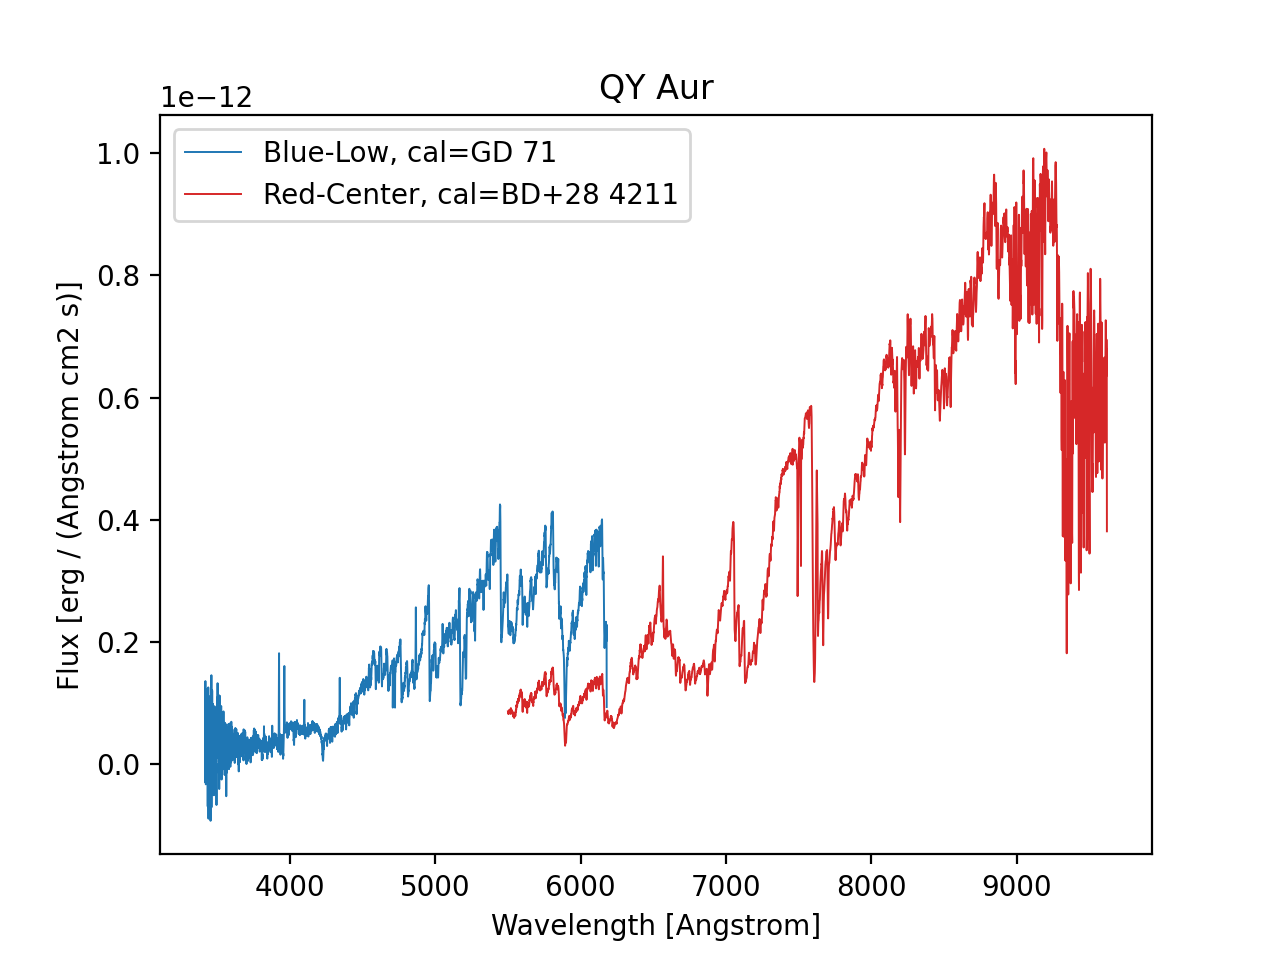

In [198]:
plt.plot(final_bluelow.wavelength, final_bluelow.flux, c='C0', lw=0.7, label='Blue-Low, cal=GD 71')
plt.plot(final_redcent.wavelength, final_redcent.flux, c='C3', lw=0.7, label='Red-Center, cal=BD+28 4211')
# plt.errorbar(final_redcent.wavelength.value, final_redcent.flux.value, 
#              yerr=final_redcent.uncertainty.array, alpha=0.2, c='C5')

plt.legend()
plt.xlabel('Wavelength ['+str(final_redcent.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_redcent.flux.unit)+']')
plt.title('QY Aur')
plt.savefig('QY Aur.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

<IPython.core.display.Javascript object>


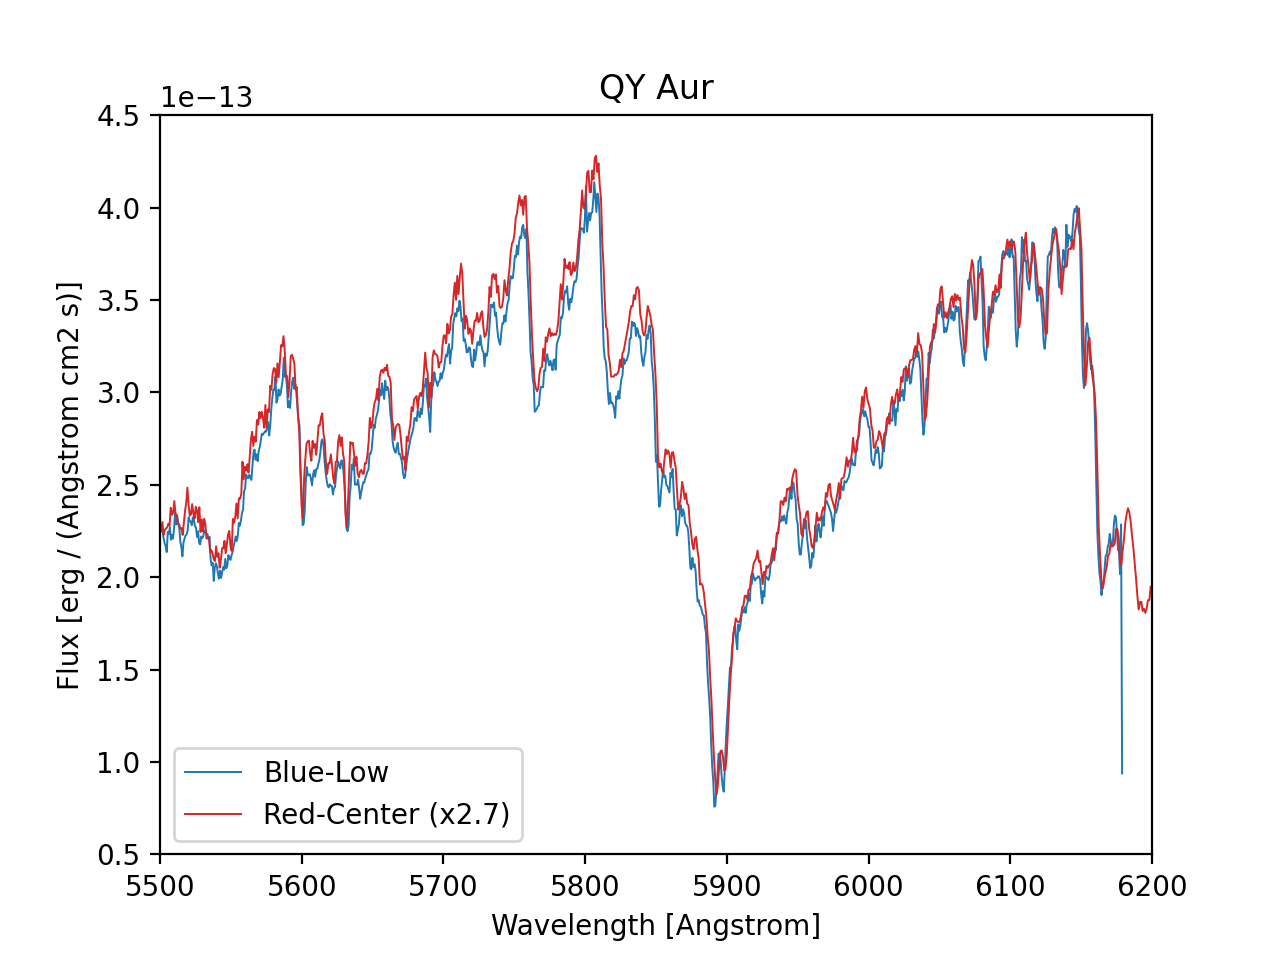

In [199]:
plt.plot(final_bluelow.wavelength, final_bluelow.flux, c='C0', lw=0.7, label='Blue-Low')
plt.plot(final_redcent.wavelength, final_redcent.flux*2.7, c='C3', lw=0.7, label='Red-Center (x2.7)')
# plt.errorbar(final_redcent.wavelength.value, final_redcent.flux.value, 
#              yerr=final_redcent.uncertainty.array, alpha=0.2, c='C5')

plt.legend()
plt.xlabel('Wavelength ['+str(final_redcent.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_redcent.flux.unit)+']')
plt.title('QY Aur')
plt.xlim(5500,6200)
plt.ylim(0.5e-13, 4.5e-13)
plt.savefig('QY Aur overlap.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<IPython.core.display.Javascript object>


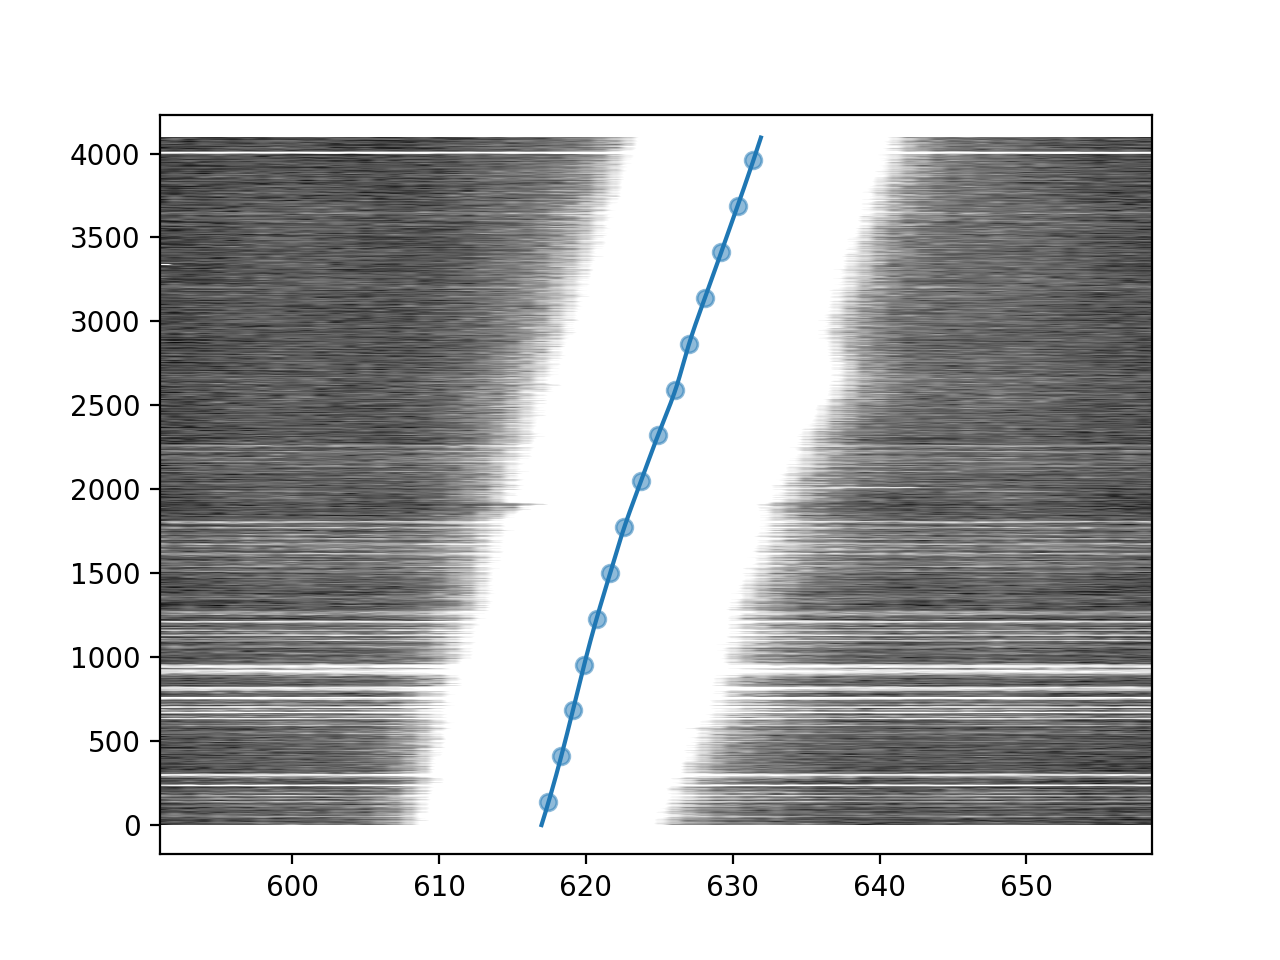

In [253]:
cal_trace = kosmos.trace(calimg, display=True, nbins=15, Waxis=0, window=50)



In [221]:
# let's reduce the blue-side of BD28 also, see if that flux calibrates better?
# BLUE-LOW 
fcal = 'bd28_4211.0004.fits'  # spectrum of standard star
calimg = kosmos.proc(fcal, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0)

cal_trace = kosmos.trace(calimg, display=False, nbins=15, Waxis=0, window=50)
cal_ex, cal_sky = kosmos.BoxcarExtract(calimg, cal_trace, display=False, 
                                       apwidth=10, skysep=10, skywidth=10, Waxis=0)

cal_spectrum = cal_ex - cal_sky

arcfile1 = 'int_neon_bd28_4211.0004.fits'
arcfile2 = 'int_kry_bd28_4211.0001.fits'

arcimg1 = kosmos.proc(arcfile1, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0) 
arcimg2 = kosmos.proc(arcfile2, bias=bias, ilum=ilum, flat=flat, trim=False, Waxis=0) 

calNe_ex, _ = kosmos.BoxcarExtract(arcimg1, cal_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)
calKr_ex, _ = kosmos.BoxcarExtract(arcimg2, cal_trace, apwidth=3, skysep=5, skywidth=5, Waxis=0)

calarc = calNe_ex/100
calarc = calarc + calKr_ex

# our blue template
df_spec1 = pd.read_csv('blue_low_Krypton_gp.spec')
df_spec2 = pd.read_csv('blue_low_Neon_gp.spec')

# make it w/ just Kr and Ne (internals), and scale Neon/100
blue_low = Spectrum1D(spectral_axis=df_spec1['wave'].values * u.angstrom,
                      flux=(df_spec1['flux'].values + 
                            (df_spec2['flux'].values/100)) * u.adu)

xbl,wbl = kosmos.identify_dtw(calarc, blue_low, upsample=False, 
                            open_begin=True, open_end=True, step_pattern='asymmetric',
                            display=False, peak_spline=True, pthreshold=0.95)

cal_fit, _ = kosmos.fit_wavelength(cal_spectrum, xbl, wbl, mode='gp', display=False, 
                                        returnvar=True, GPRscale=101)
ZD = calimg.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)
cal_fitX = kosmos.airmass_cor(cal_fit, cal_airmass, Xfile)

standardstar = kosmos.onedstd('spec50cal/bd284211.dat')
sensfunc = kosmos.standard_sensfunc(cal_fitX, standardstar, mode='poly', polydeg=9, display=False)

final_bluelow_cal = kosmos.apply_sensfunc(cal_fitX, sensfunc)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:316: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +
/Users/james/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:2559: RuntimeWarning: invalid value encountered in true_divide
  norm_distances.append((x - grid[i]) /


<IPython.core.display.Javascript object>


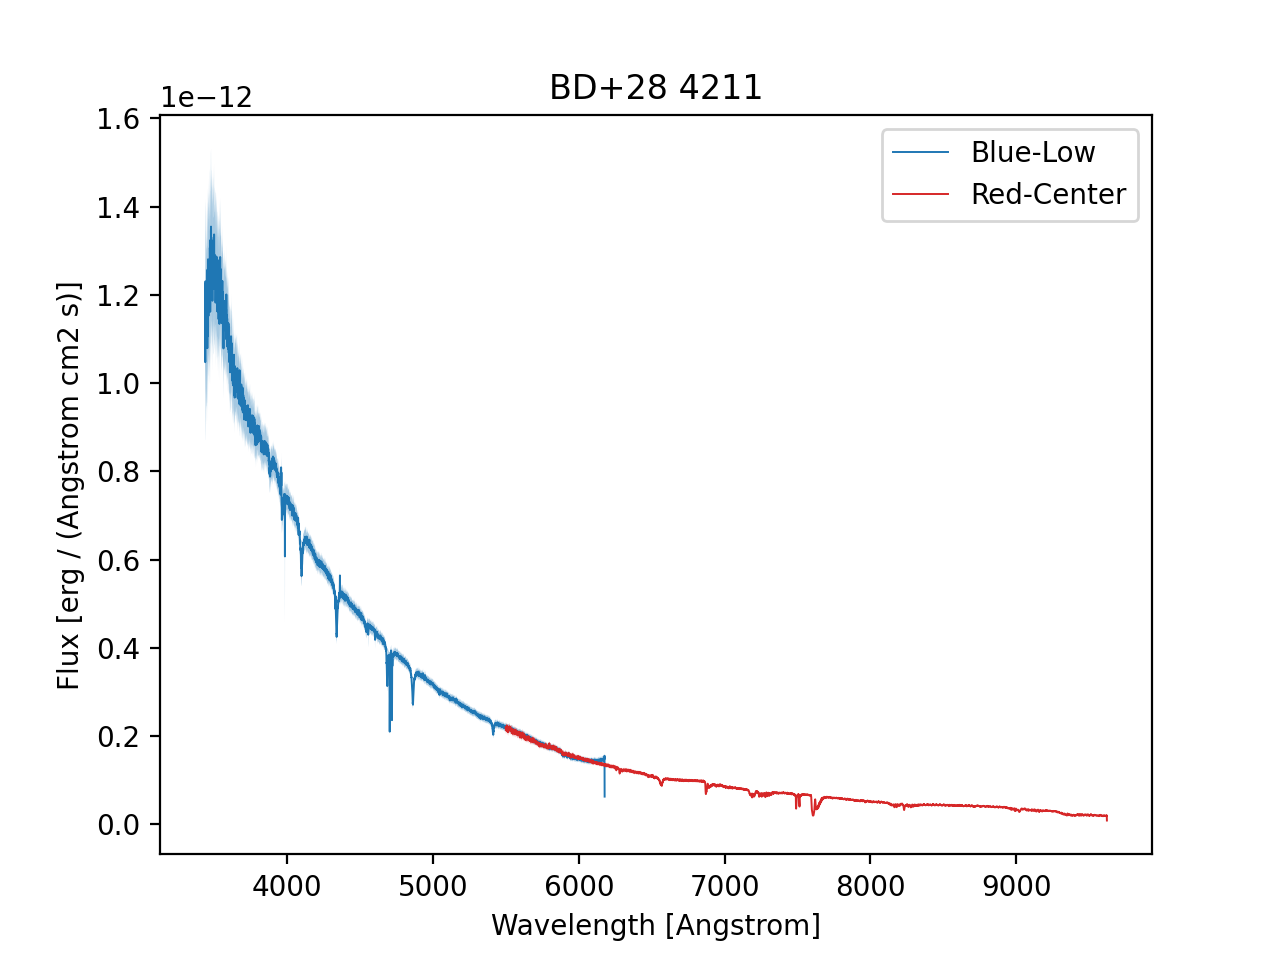

In [250]:
plt.fill_between(final_bluelow_cal.wavelength.value, 
                 final_bluelow_cal.flux.value - final_bluelow_cal.uncertainty.array, 
                 final_bluelow_cal.flux.value + final_bluelow_cal.uncertainty.array, 
                 alpha=0.4, color='C0', edgecolor=None)
plt.plot(final_bluelow_cal.wavelength, final_bluelow_cal.flux, c='C0', lw=0.7, label='Blue-Low')

plt.fill_between(final_redcent_cal.wavelength.value, 
                 final_redcent_cal.flux.value - final_redcent_cal.uncertainty.array, 
                 final_redcent_cal.flux.value + final_redcent_cal.uncertainty.array, 
                 color='C3', alpha=0.4, edgecolor=None)
plt.plot(final_redcent_cal.wavelength, final_redcent_cal.flux, c='C3', lw=0.7, label='Red-Center')

# plt.scatter(standardstar['wave'], standardstar['flux'], c='C1', alpha=0.5)
plt.xlabel('Wavelength ['+str(final_bluelow_cal.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_bluelow_cal.flux.unit)+']')
plt.title('BD+28 4211')
plt.legend()


In [261]:
print(np.mean(np.abs(final_bluelow.wavelength.value[1:]/np.diff(final_bluelow.wavelength.value))),
np.mean(np.abs(final_redcent.wavelength.value[1:]/np.diff(final_redcent.wavelength.value))))


6955.141310182905 7408.700880452737


<IPython.core.display.Javascript object>


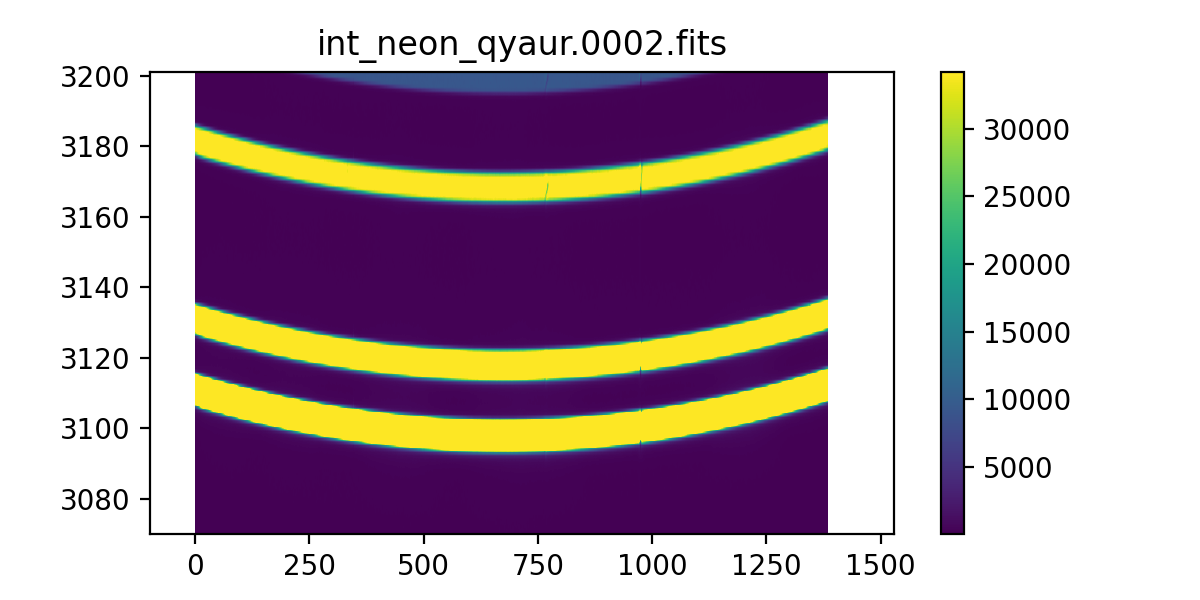

Text(0.5, 1.0, 'int_neon_qyaur.0002.fits')

In [260]:
plt.figure(figsize=(6,3))
plt.imshow(arcimg1, origin='lower', aspect='auto')
plt.clim(np.percentile(arcimg1, (5, 98)))
cb = plt.colorbar()
plt.title(arcfile1)
# plt.ylim(950,1020)